# ZILLOW

## Project goal

- Find the key drivers of property value for single family properties.
- Construct an ML Regression model that predicts propery tax assessed values.
- Make recommendations on what works or doesn't work in predicting these homes' values

In [5]:
import pandas as pd
import numpy as np
import warnings
import geocoder

import matplotlib.pyplot as plt
import seaborn as sns

from mock import train_val_test, xy_split, scaled_data, clean_and_converts
from mock2 import eval_model, train_model, pearson_correlation, create_scatter_plot, plot_tax_value_by_fips, perform_anova, scatter_plot_bedrooms_vs_tax_value, pearson_correlation_test, create_barplot
from env import get_connection

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor

from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.model_selection import GridSearchCV
from scipy import stats

## Acquire

- Acquiring specific columns that i need for the project from the zillow dataset using sql.
- Read the sql query into a dataframe.
- It contained 52_441 rows and 22 columns before cleaning

## Prepare data

* Create new columns by transforming and utilizing existing data features.
    - Changed column names to something readable.
    - Dropped all 2414 rows with null values in the df.
    - Binned different values in specific columns.
    - Created 2 different columns to represent county and state.
    - One-hot encode categorical culomns with get dummies.

## Data Dictionary

| Feature                | Definition | Data Type |
|:-----------------------|:-----------|:----------|
| finishedsquarefeet12   | Finished square footage of the property | float64 |
| squarefeet             | Square footage of the property | float64 |
| latitude               | Latitude coordinate of the property | float64 |
| regionidzip            | Region ID of the property's ZIP code | float64 |
| longitude              | Longitude coordinate of the property | float64 |
| lotsizesquarefeet      | Square footage of the property's lot | float64 |
| logerror               | Logarithm of the error in the property's Zillow estimate | float64 |
| year_built             | Year the property was built | float64 |
| id                     | Identifier for the property | int64 |
| rawcensustractandblock | Raw census tract and block identifier | float64 |
| regionidcity           | Region ID of the property's city | float64 |
| bathrooms              | Number of bathrooms in the property | float64 |
| bedrooms               | Number of bedrooms in the property | float64 |
| fips                   | Federal Information Processing Standards (FIPS) code for the property's location | float64 |
| tax_value              | Property tax value | float64 |
| bedrooms_bin           | Categorical variable representing a bin for the number of bedrooms | category |
| bathrooms_bin          | Categorical variable representing a bin for the number of bathrooms | category |
| squarefeet_bin         | Categorical variable representing a bin for the square footage of the property | category |
| decades                | Categorical variable representing the decade in which the property was built | category |

In [6]:
# acquiring, cleaning, and adding features to data
# Call the clean_and_convert() function to obtain a cleaned and converted DataFrame.
df = clean_and_converts()

# Split the DataFrame 'df' into training, validation, and test sets using the train_val_test function.
train, val, test = train_val_test(df)

### A concise summary of the data

In [7]:
#using.info() to check all the data types and null values

train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35018 entries, 12650 to 16552
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   finishedsquarefeet12    35018 non-null  float64 
 1   squarefeet              35018 non-null  float64 
 2   latitude                35018 non-null  float64 
 3   regionidzip             35018 non-null  float64 
 4   longitude               35018 non-null  float64 
 5   lotsizesquarefeet       35018 non-null  float64 
 6   logerror                35018 non-null  float64 
 7   year_built              35018 non-null  float64 
 8   id                      35018 non-null  int64   
 9   id                      35018 non-null  int64   
 10  rawcensustractandblock  35018 non-null  float64 
 11  regionidcity            35018 non-null  float64 
 12  parcelid                35018 non-null  int64   
 13  parcelid                35018 non-null  int64   
 14  bathrooms              

### Explore

# Does squarefeet affect tax value?

#### Creating a scatterplot to visualize the relationship between square feet and tax value.

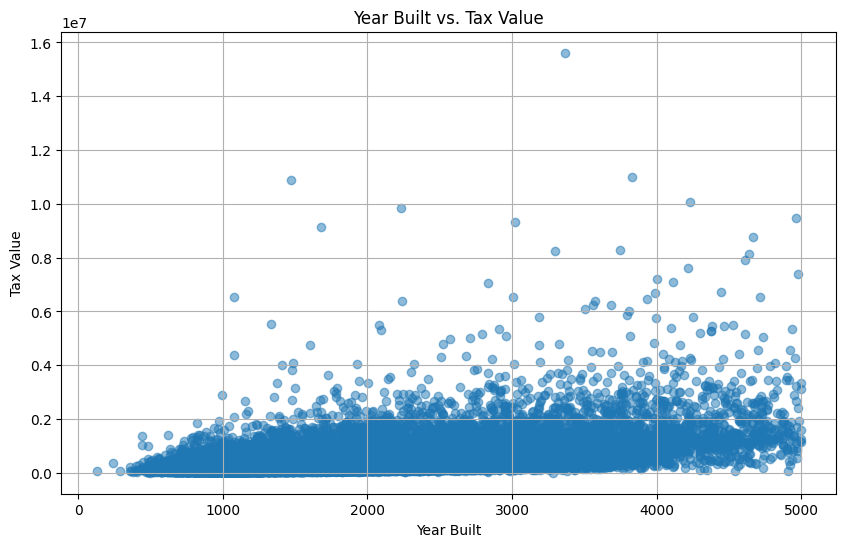

In [8]:
create_scatter_plot(train, 'squarefeet', 'tax_value')

#### Takeaway

From the scatterplot we can deduce that there is somewhat of a relationship between squarefeet and tax value because as square feet increases, the tax_value moderately increases.

### Pearson's Correlation Coefficient (r)

Null hypothesis: There is no significant linear correlation between squarefeet and tax_value in the population. 

Alternative hypothesis: There is a significant linear correlation between squarefeet and tax_value in the population. 

I will now use a Pearson's Correlation Coefficient (r) to investigate whether squarefeet affects tax_value

I will use a confidence interval of 95%  
The resulting alpha is .05

In [9]:
pearson_correlation(train.squarefeet, train.tax_value)

('We reject the null hypothesis. There appears to be a relationship.',
 'r = 0.523709059802853.',
 'p = 0.0.')

#### Takeaway

- The value of r is approximately 0.524, which indicates the strength and direction of the linear relationship.  
- The p-value is very close to zero (0.0), which means it's highly statistically significant.

# Does FIPS affect tax value?

#### Creating a barplot to visualize the relationship between the FIPS region and tax value.

/opt/homebrew/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


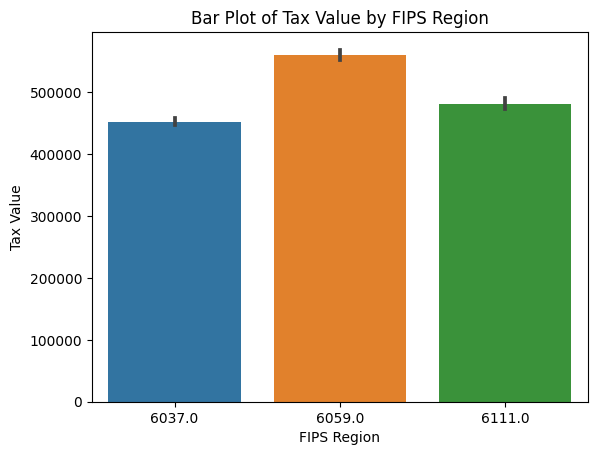

In [10]:
plot_tax_value_by_fips(df)

#### Takeaway

- It appears that there is variation in tax_value among the different FIPS regions. FIPS 6059, in particular, stands out with the highest median tax_value, while FIPS 6037 has the lowest median tax_value. This suggests that the FIPS region may be a key driver of property value, as there is a significant difference in tax_value among these regions.

### ANOVA test

Null Hypothesis: There is no significant difference in tax values among the different FIPS regions.  

Alternative Hypothesis: There is a significant difference in tax values among at least two of the FIPS regions.

- This test investigates whether there are significant differences in tax_value among different FIPS regions.

In [11]:
perform_anova(df, alpha=0.05)

('We reject the null hypothesis. There is a significant difference among FIPS regions.',
 2.1641653140251805e-90)

#### Takeaway

- The p-value provides strong evidence to conclude that at least one of the FIPS regions has a significantly different tax value from the others.

# Is there a correlation between tax value and number of bedrooms?

#### Creating a barplot to visualize the correlation between tax value and the number of bedrooms.

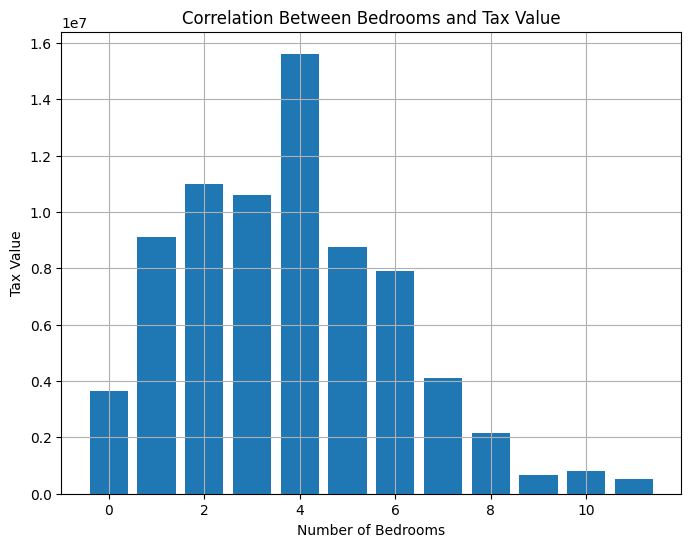

In [12]:
scatter_plot_bedrooms_vs_tax_value(df.bedrooms, df.tax_value)

#### Takeaway

- The chart shows that on average 2 and 4 bedroom houses have the highest tax value.

### Pearson's Correlation Coefficient (r)

Null Hypothesis: There is no correlation between the number of bedrooms and tax_value for single-family properties.   

Alternative Hypothesis: There is a correlation between the number of bedrooms and tax_value for single-family properties.

I will now use a Pearson's Correlation Coefficient (r) to investigate whether there a correlation between tax value and number of bedrooms.

I will use a confidence interval of 95%  
The resulting alpha is .05

In [13]:
pearson_correlation_test(df.bedrooms, df.tax_value)

('We reject the null hypothesis. There is a correlation between tax value and number of bedrooms.',
 0.22246526953130105,
 0.0)

#### Takeaway

- The analysis conducted indicates a statistically significant, positive correlation between the number of bedrooms and property tax values. This suggests that, on average, properties with more bedrooms tend to have higher tax values. However, it's important to note that correlation does not imply causation, and other factors may also influence tax values. Further investigation and consideration of additional variables are recommended for a more comprehensive understanding of property tax determinants.

### Scatterplot

# Does the year the property was built affect the value?

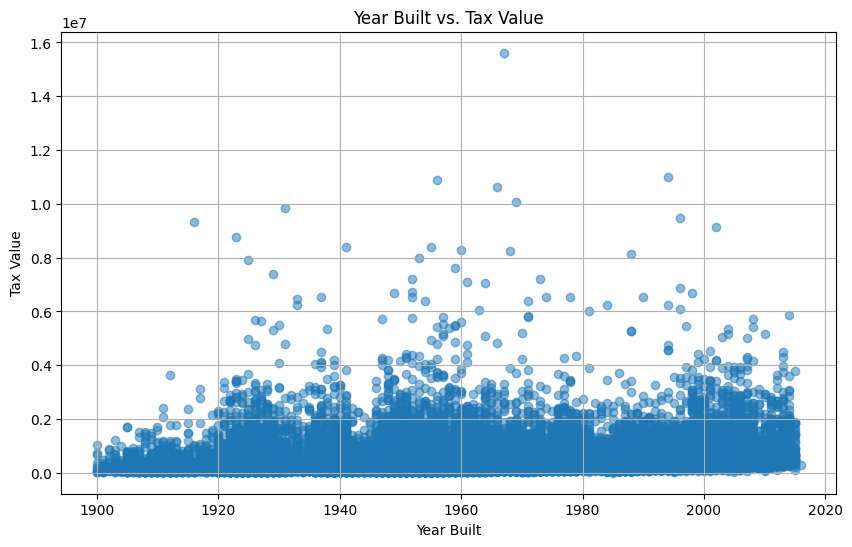

In [14]:
create_scatter_plot(df, 'year_built', 'tax_value')

/opt/homebrew/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


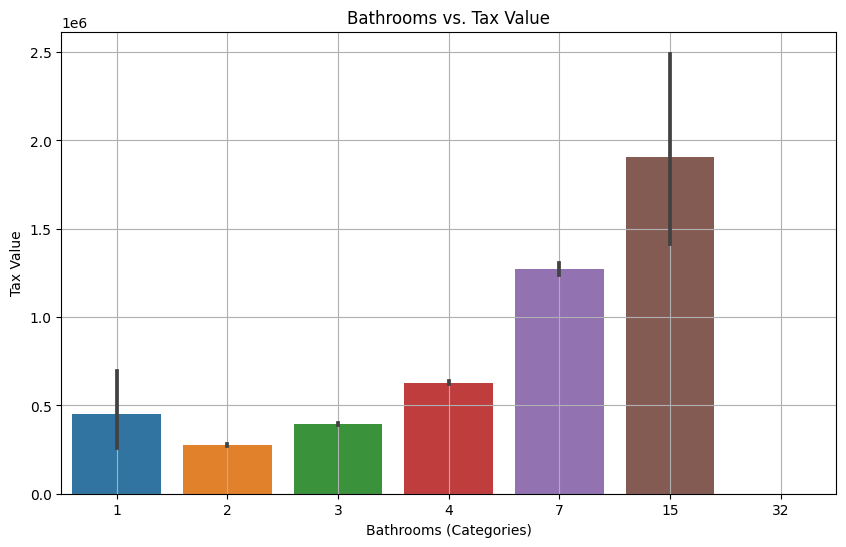

In [15]:
create_barplot(df, 'bathrooms_bin', 'tax_value')